In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-23


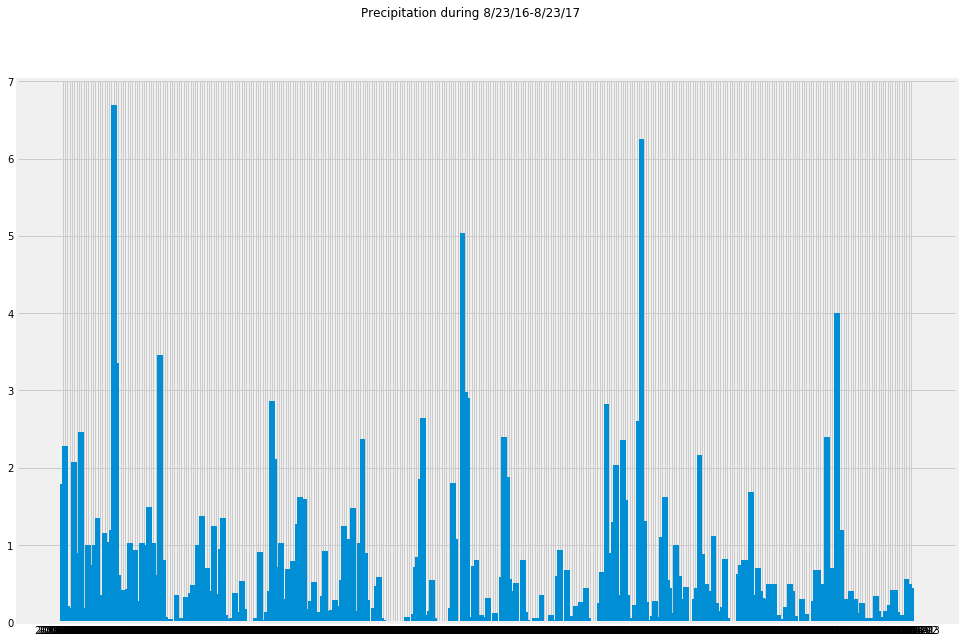

,Prcp
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date,'%Y-%m-%d').date()
print(last_date)
year_ago = last_date - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year,columns=['Date','Prcp']).set_index('Date')

# Sort the dataframe by date
df=df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
fig,ax = plt.subplots(figsize = (15,10))
plt.grid(b=True, axis ='both',which='major')
ax.bar(df.index.values,df['Prcp'],width=2.5)

# ax.grid(linestyle='-')
# ax.bar(df_Precip["Date"], df_Precip["Precipitation"], width=4)
fig.suptitle('Precipitation during 8/23/16-8/23/17')

# plt.xticks([])
# xtick = pd.date_range( start=ts.index.min( ), end=ts.index.max( ), freq='W' )
ax.grid('off', which='minor', axis='x' )
plt.show()
df

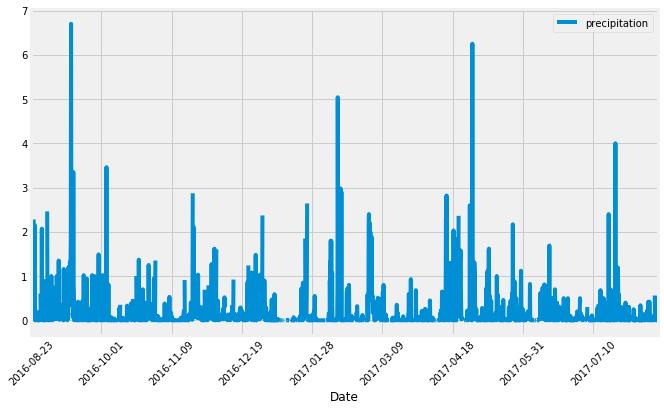

In [73]:
df.Prcp.plot(label = 'precipitation', figsize= (10, 6), rot=45)
plt.legend()
plt.show()

![precipitation](Images/precipitation.png)

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [98]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count((Measurement.station).distinct())).first()

(9)

In [85]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(f'The most active station is {stations[0][0]} with {stations[0][1]} observations.')

stations

The most active station is USC00519281 with 2772 observations.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

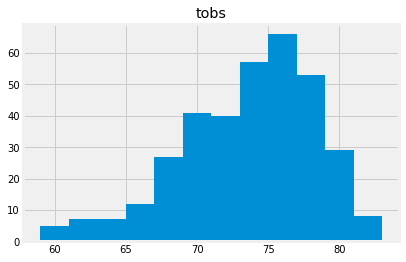

In [117]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station==stations[0][0]).filter(Measurement.date>=year_ago).order_by(Measurement.tobs.asc()).all()
# print(results)
df = pd.DataFrame(results)
df.hist(column='tobs',bins=12)
plt.show()

## Optional Challenge Assignment

### Temperature Analysis I

In [33]:
import scipy.stats as stats
june = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="06").all()
dec = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="12").all()
print(f'June mean: {np.ravel(june).mean()}')
print(f'Dec mean: {np.ravel(dec).mean()}')
print(f'We use an un-paired t-test to determine whether or not the two populations are significantly different from one another.')
print(stats.ttest_ind(np.ravel(june),np.ravel(dec)))
print(f'The p-value is lower than 0.05, therefore the null hypothesis is rejected and there is a significant differnce between the populations.')


June mean: 74.94411764705882
Dec mean: 71.04152933421226
We use an un-paired t-test to determine whether or not the two populations are significantly different from one another.
Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)
The p-value is lower than 0.05, therefore the null hypothesis is rejected and there is a significant differnce between the populations.


### Temperature Analysis II

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f'My trip starts on 2017-10-20 and end on 2017-10-30')
my_trip=calc_temps('2016-10-20', '2016-10-30')
print(my_trip)
temp_min=my_trip[0][0]
temp_avg=my_trip[0][1]
temp_max=my_trip[0][2]

My trip starts on 2017-10-20 and end on 2017-10-30
[(68.0, 76.35714285714286, 81.0)]


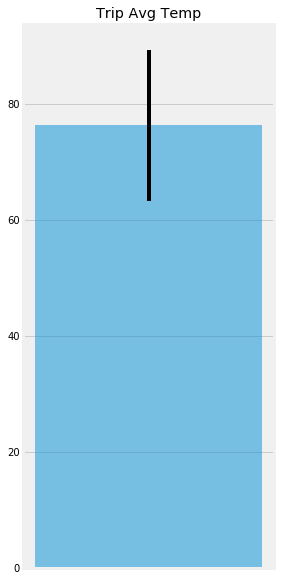

In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig,ax = plt.subplots(figsize=(4,10))
plt.bar('',temp_avg,yerr=(temp_max-temp_min),alpha=0.5)
plt.title('Trip Avg Temp')
plt.grid(False,axis='x')
plt.show()

In [90]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation]
rain = session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date.between('2016-10-20', '2016-10-30')).order_by(Measurement.prcp.desc()).all()
rain_df = pd.DataFrame(rain)
rain_df_group=rain_df.groupby(["station","latitude","longitude","elevation"]).sum()
rain_df_group

,,,,prcp
station,latitude,longitude,elevation,
USC00513117,21.42340,-157.80150,14.6,0.61
USC00514830,21.52130,-157.83740,7.0,0.72
USC00516128,21.33310,-157.80250,152.4,6.62
USC00517948,21.39340,-157.97510,11.9,0.60
USC00519281,21.45167,-157.84889,32.9,0.90
USC00519397,21.27160,-157.81680,3.0,0.48
USC00519523,21.33556,-157.71139,19.5,0.29


In [92]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
for i in range(11):
    normals.append(daily_normals(f"10-{20+i}")[0])
normals
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(67.0, 74.79629629629629, 82.0),
 (66.0, 74.96078431372548, 82.0),
 (66.0, 74.84313725490196, 81.0),
 (66.0, 75.74468085106383, 84.0),
 (69.0, 74.98039215686275, 81.0),
 (68.0, 75.0, 81.0),
 (68.0, 75.17307692307692, 81.0),
 (64.0, 75.12, 81.0),
 (68.0, 74.75471698113208, 82.0),
 (68.0, 74.88679245283019, 81.0),
 (64.0, 74.66, 81.0)]

In [99]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
